---

# **Sentiment Induction using the Bible as a Parallel Corpus**

---

## Introduction

In the field of sentiment analysis (eg. the labeling of text as positive or negative), one of the simplest and lightweight methods is lexicon based sentiment analysis (Roul, 2021).
Lexicon based analysis can consist of using a collection of words, and phrases with a label or rating attached, that can be compared with another piece of text to determine the sentiment of the text.

This the accuracy of this method however heavily relies on the size of the lexicon and the accuracy of the ratings, and as the lexicons are many times manually built and labeled/rated, these lexicons aren't widely available in a lesser used language, or if available is fairly limited in size or scope. 
For example, the Afrikaans lexicon provided by Kaggle's "Sentiment Lexicons for 81 Languages" article (Tatman) provides 1390 negative and 910 positive words, but these words are not ranked or rated, only provided as groups.
This lexicon also contains many words from other languages as well as words not commonly used in Afrikaans.

This proposal attempts to investigate the feasibility of using parallel corpora (<i>Parallel corpus - Glottopedia</i>) to transfer sentiment (induce) between text, thereby allowing lexicon, machine learning, or hybrid sentiment analysis to be performed on the primary corpus, and then have the sentiment transferred to the secondary, from which a new lexicon can be built, which in turn can be used for sentiment analysis in the language of the second source.

<b>Purpose:</b> To Investigate the possibility and effectiveness of transferring sentiment between parallel corpus entities.

<b>Key Objectives:</b>
<ul>
    <li>Import and Build the parallel corpus</li>
    <li>Run sentiment analysis against the first entity group</li>
    <li>Transfer the sentiment score to the parallel entity group</li>
    <li>Calculate the sentiment averages for words in the parallel entity group</li>
    <li>Evaluate the induced sentiment</li>
    <li>Compile a sentiment lexicon to be used on external sources</li>
</ul>

<b>Why use the bible?</b>

Using the bible translations provides a strong parallel, multi-language dataset, using reliable translation.



This is done under the assumption that verses should have similar sentiment score in different versions and languages.

<b>Analysis & Key Findings:</b>
<ul>
    <li>Sentiment can easily be transferred between the corpuses</li>
    <li>There is a clear distinction between the positive and negative words using induced sentiment</li>
</ul>

<b>Notes:</b>
<ul>
    <li>Although all sources (primary and secondary) used here is english, this can easily be easily substituted for a different language.
    <br/>This would also be the ultimate goal of sentiment induction.
    <br/>The use of the King James 1769 in this case is as a stand-in for the other language, while keeping the results understandable for a casual viewer.
    </li>
    </li>
</ul>

<hr>

## Prepare Environment

### Load Packages

In [1]:
#Read/Write Data
import os
from zipfile import ZipFile
import sqlite3

#Data Retrieval
import requests

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

#Data Processing/Analysis
import pandas as pd
import numpy as np
from statistics import mean
import re
import string
from itertools import groupby

#NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, word_tokenize, RegexpParser, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Miscellaneous
import swifter

<hr>

## Load Primary Corpus
<b>Objectives:</b>
<ul>
    <li>Define a "Bible" class</li>
    <li>Define a function to load a list of bibles into a Pandas Dataframe with the provided details (Connection Path, Language, Name, Name Shorthand)</li>
    <li>Display the Dataframe</li>
    <li>Generate and display a summary of the DataFrame</li>
</ul>

### The "bible" class

In [2]:
class bible:
    ConnectionPath: str
    Corpus: str
    Name: str
    Source: str
    NameShorthand: str
    
    def __init__(self, connectionPath, corpus, source, name, nameShorthand =""):
        self.ConnectionPath = connectionPath
        self.Corpus = corpus
        self.Name = name
        self.Source = source
        self.NameShorthand = nameShorthand

### Function to download and extract sources class
Only downloads if not available locally

1. Download missing corpus files:
- The function starts by setting the path for the zip files as 'zipped'.
- It checks if the 'zipped' directory exists. If not, it creates it.
- It retrieves the list of files in the 'zipped' directory.
- It loops through the bibles to check if their corresponding zip files exist in the 'zipped' directory.
- For each missing zip file, it downloads the file using the bible's source URL and saves it in the 'zipped' directory.

2. Extract un-extracted files:

- The function sets the path for the extracted files as 'corpus'.
- It checks if the 'corpus' directory exists. If not, it creates it.
- It loops through the bibles, grouping them by their corpus.
- For each unique corpus, it creates a corresponding folder in the 'corpus' directory.

3. Extract SQLite3 files:

- For each bible in the list, it checks if the corresponding SQLite3 file exists in the corpus folder.
- If the file doesn't exist, it opens the corresponding zip file using the bible's shorthand name.
- It extracts the SQLite3 file from the zip file and saves it in the appropriate corpus folder.

In [3]:
def fetchCorpus(bibles: list[bible]):
    #Download missing corpus files
    zipPath = 'zipped'

    if not os.path.exists(zipPath):
        os.makedirs(zipPath)

    zippedFiles = os.listdir(zipPath)

    # Loop through the bibles to check if their corresponding zip files exist
    for bible in filter(lambda x: f"{x.NameShorthand}.zip" not in zippedFiles, bibles):
        print(f"Downloading: {bible.NameShorthand}.zip")
        response = requests.get(bible.Source)
        open(f"{zipPath}/{bible.NameShorthand}.zip", "wb").write(response.content)
    
    #Extract un-extracted files
    extractedPath = "corpus"
    
    if not os.path.exists(extractedPath):
        os.makedirs(extractedPath)
        print(f"Created: {extractedPath}")
    
    # Group the bibles by their corpus and process them
    for corpusGroup in groupby(bibles, lambda x: x.Corpus):
        corpusFolderName = f"{extractedPath}/{corpusGroup[0]}"
        if not os.path.exists(corpusFolderName):
            os.makedirs(corpusFolderName)
            print(f"Created: {corpusFolderName}")
        
        corpusFiles = os.listdir(extractedPath)
    
    # Loop through each bible and extract its SQLite3 file if it doesn't already exist
    for bible in bibles:
        path = f"{extractedPath}/{bible.Corpus}"
        if not os.path.exists(f"{extractedPath}/{bible.Corpus}/{bible.NameShorthand}.SQLite3"):
            with ZipFile(f"{zipPath}/{bible.NameShorthand}.zip", 'r') as zObject:
                print(f"Extracting: {bible.NameShorthand}.SQLite3")
                zObject.extract(f"{bible.NameShorthand}.SQLite3",path=path)

### Function to load bibles into a DataFrame

The `loadBibles` function extends the functionality of a Pandas DataFrame. It takes a list of `bible` objects as input.

For each `bible` object, it constructs a file path to a SQLite3 file, connects to the file, executes a SQL query to retrieve data from a table called 'verses', and stores the result in a DataFrame. It adds a new column to the DataFrame to store the name of the bible version.

The function then concatenates the newly created DataFrame with the existing DataFrame, and returns the updated DataFrame.

Finally, the function is added as a method to the `pd.DataFrame` class, allowing any DataFrame instance to call it.

In [4]:
def loadBibles(self: pd.DataFrame, bibles: list[bible]):
    corpusFolder = "corpus"
    for bible in bibles:
        filePath = f"{corpusFolder}/{bible.Corpus}/{bible.NameShorthand}.SQLite3"
        
        con = sqlite3.connect(filePath)
        df = pd.read_sql_query('SELECT * FROM verses', con)
        con.close()
        
        df["bible_version"] = bible.Name

        self = pd.concat([self, df], ignore_index=True)
    
    return self
        
pd.DataFrame.loadBibles = loadBibles

### Define list of corpus sources and details

To test the minimum requirement is at least 1 "en1" corpus as well as a different "en2" corpus.

Having a larger corpus size will result in a more representative and larger sentiment lexicon output.

In [5]:
bibles = [
    bible("en/NIV'11.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=NIV%2711&b=mybible&c", 'New International Version 2011',"NIV'11"),
    bible("en/NLT.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=NLT&b=mybible&c", 'New Living Translation 2013',"NLT"),
    bible("en/ESV.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=ESV&b=mybible&c", 'English Standard Version 2011',"ESV"),
    bible("en/CSB'17.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=CSB%2717&b=mybible&c", 'Christian Standard Bible 2017',"CSB'17"),
    bible("en/MSG.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=MSG&b=mybible&c", 'The Message 2002',"MSG"),
    bible("en/NKJV.SQLite3","en1", "https://www.ph4.org/_dl.php?back=bbl&a=NKJV&b=mybible&c", 'New King James Version 1982',"NKJV"),
    bible("en/KJ'1769.SQLite3","en2", "https://www.ph4.org/_dl.php?back=bbl&a=KJ%271769&b=mybible&c", 'King James Version 1769',"KJ'1769")
]

### Load the corpus

In [6]:
fetchCorpus(bibles) 
#The initial download usually takes about 2 minutes for 7 bibles.

Downloading: NIV'11.zip
Downloading: NLT.zip
Downloading: ESV.zip
Downloading: CSB'17.zip
Downloading: MSG.zip
Downloading: NKJV.zip
Downloading: KJ'1769.zip
Created: corpus
Created: corpus/en1
Created: corpus/en2
Extracting: NIV'11.SQLite3
Extracting: NLT.SQLite3
Extracting: ESV.SQLite3
Extracting: CSB'17.SQLite3
Extracting: MSG.SQLite3
Extracting: NKJV.SQLite3
Extracting: KJ'1769.SQLite3


As seen in the `bibles` list, the last element of the list is in the `en2` group, while the rest is in `en1`, this allows both the primary and secondary corpus to be downloaded, and then later used as required.

In [7]:
df_corpus = pd.DataFrame()
df_en = df_corpus.loadBibles(filter(lambda x: f"{x.Corpus}" == 'en1', bibles))

In [8]:
display(HTML('<h3>Corpus Samples:</h3>'))
df_en.sample(10)

,book_number,chapter,verse,text,bible_version
159470,40,8,17,<f>[19†]</f>For all the firstborn among the ch...,New King James Version 1982
141211,240,14,27,The Fear-of-God is a spring of living water<br...,The Message 2002
30912,730,13,4,People worshiped the dragon because he had giv...,New International Version 2011
153315,540,6,5,"when we're beaten up, jailed, and mobbed; work...",The Message 2002
152773,520,16,25,All of our praise rises to the One who is stro...,The Message 2002
122463,550,4,24,"These things are being taken figuratively, for...",Christian Standard Bible 2017
126528,20,22,3,"But if it happens after daybreak, there is blo...",The Message 2002
1017,10,35,6,<pb/>Jacob and all the people with him came to...,New International Version 2011
119,10,5,14,"Altogether, Kenan lived a total of 910 years, ...",New International Version 2011
17861,290,10,11,<t>shall I not deal with Jerusalem and her ima...,New International Version 2011


Here we can see some of the entries in the corpus

Things to take note of:
- Book numbers contain trailing 0's
- The text contains HTML elements

### Overview

This codeblock generates a summary of the different bibles, this is useful to identify any variation between their content.

In [9]:
df_meta = pd.DataFrame(df_en)
df_meta['book_chapter'] = df_en[['book_number', 'chapter']].astype(str).agg('-'.join, axis=1)
df_meta['book_chapter_verse'] = df_en[['book_number', 'chapter','verse']].astype(str).agg('-'.join, axis=1)
df_meta['word_count'] = df_en['text'].apply(
    lambda row: min(len(row.split(" ")), len(row)) if isinstance(row, str) else 0
)
df_summary =  df_meta.groupby('bible_version').agg(
    books = pd.NamedAgg(column="book_number", aggfunc = (lambda x: len(pd.Series.unique(x)))),
    chapters = pd.NamedAgg(column="book_chapter", aggfunc = (lambda x: len(pd.Series.unique(x)))),
    verses = pd.NamedAgg(column="book_chapter_verse", aggfunc = (lambda x: len(pd.Series.unique(x)))),
    avg_verse_length = pd.NamedAgg(column="word_count", aggfunc = 'mean'),
    word_count = pd.NamedAgg(column="word_count", aggfunc = 'sum'),
)
display(HTML('<h3>Corpus Summary:</h3>'))
df_summary

,books,chapters,verses,avg_verse_length,word_count
bible_version,,,,,
Christian Standard Bible 2017,66,1189,31103,24.719416,768848
English Standard Version 2011,66,1189,31103,24.762467,770187
New International Version 2011,66,1189,31102,23.423285,728511
New King James Version 1982,66,1189,31102,25.003054,777645
New Living Translation 2013,66,1189,31104,24.343139,757169
The Message 2002,66,1189,31102,22.764292,708015


Notes from the summary:
- The word counts range from 700k to 780k, and the average verse length range from 22.7 to 25 words.
- Books and chapters are constant but there are a difference of 2 verses between bibles

<hr>

### Data Pre-processing

**Objectives:**
+ Define a function clean the html formatting present in the verses, this is done with regex
+ Wordcloud overview of the corpus

**Notes:**
+ Although stopwords are removed from the text for the analysis/overview and wordcloud generation, this is not necessary for the sentiment analysis, as VADER does utilize stopwords.

In [10]:
stopwords = list(nltk.corpus.stopwords.words("english"))
punctuation = list(string.punctuation)

def preprocess_text_en(text, removePunctuation = False, removeStopwords = False):
    #remove html
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    
    #remove strange characters
    text = text.replace("“","\"")
    text = text.replace("”","\"")
    text = text.encode("ascii",'ignore').decode('ascii','ignore')
    
    if removePunctuation:
        text = "".join([i for i in text if i not in punctuation])
        text = text.lower()

    text = re.sub(' +', ' ', text)
    words = text.split(' ')
    
    if removeStopwords:
        words = [w for w in words if w.isalpha()]
        words = [w for w in words if w.lower() not in stopwords]

    text = " ".join(words)

    return text

In [11]:
df_en["cleanText"] = df_en["text"].apply(preprocess_text_en)

display(HTML('<h3>English Bibles Clean Samples:</h3>'))
df_en[["text","cleanText"]].sample(10)

,text,cleanText
23905,"<pb/>When the crowds heard this, they were ast...","When the crowds heard this, they were astonish..."
173760,<t>You shall have a song </t><t>As in the nigh...,You shall have a song As in the night when a h...
163362,And David said to Saul: <f>[10†]</f>“Why do yo...,"And David said to Saul: ""Why do you listen to ..."
117916,<J>You know the commandments: <e>Do not murder...,You know the commandments: Do not murder; do n...
114790,"He spoke to me: “Son of man, look with your ey...","He spoke to me: ""Son of man, look with your ey..."
89530,If then<f>ⓜ</f> God gave<f>ⓝ</f> the same gift...,If then God gave the same gift to them as he g...
113859,"Take some more of them, throw them into the fi...","Take some more of them, throw them into the fi..."
8394,"<pb/>Also, whenever anyone approached him to b...","Also, whenever anyone approached him to bow do..."
165628,"<pb/>Then Isaiah said to Hezekiah, “Hear the w...","Then Isaiah said to Hezekiah, ""Hear the word o..."
177836,<t> <f>[17†]</f>The LORD gives voice before Hi...,"The LORD gives voice before His army, For His..."


Sample Notes:
- Comparing the left and right, the HTML and Block-References have been stripped out successfully.


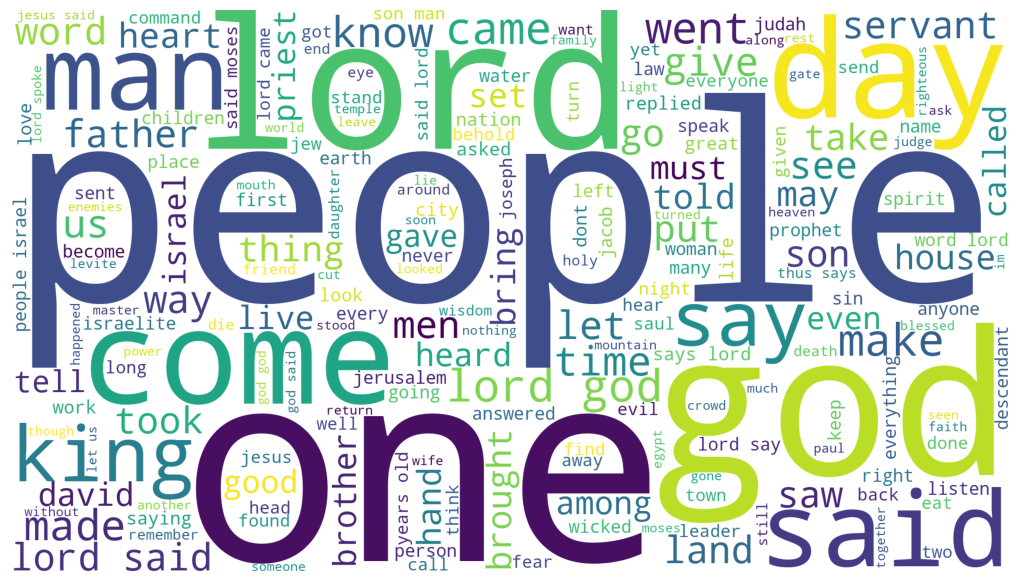

In [12]:
text = preprocess_text_en(df_en.cleanText.to_string(index=False, header = False),True,True)
wordcloud = WordCloud(width = 1920, height = 1080,
                background_color ='white',
                min_font_size = 10).generate(text)

# plot the WordCloud image                      
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('eng_wordcloud.png')

display(HTML('<h3>English bible wordcloud:</h3>'))
plt.show()

***
## Sentiment Scoring

**Objectives:**
+ Generate sentiment scores for each verse
+ Investigate score differences and distributions

**Notes:**
+ Made use of the `swifter` package (Wijaya, 2021) to process the sentiment scores in a smaller amount of time
+ Used the `vaderSentiment` package for sentiment analysis (‘Python | Sentiment Analysis using VADER’, 2019)
+ Added the positive, negative and neutral scores to aid in the analysis, using the compound score for the sentiment transfer

In [13]:
sid_obj = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    sentiment_dict = sid_obj.polarity_scores(text)
    
    return pd.Series([sentiment_dict['compound'], sentiment_dict['pos'], sentiment_dict['neg'], sentiment_dict['neu']])

In [14]:
df_en[['score_compound', 'score_pos', 'score_neg', 'score_neu']] = df_en["cleanText"].swifter.apply(sentiment_scores)

Pandas Apply:   0%|          | 0/186616 [00:00<?, ?it/s]

In [15]:
df_en.sample(10)

,book_number,chapter,verse,text,bible_version,cleanText,score_compound,score_pos,score_neg,score_neu
131541,80,1,2,The man's name was Elimelech; his wife's name ...,The Message 2002,The man's name was Elimelech; his wife's name ...,0.0000,0.000,0.000,1.000
168311,190,6,4,"<pb/>So the king said, “Who <i>is</i> in the c...",New King James Version 1982,"So the king said, ""Who is in the court?"" Now H...",0.2263,0.050,0.000,0.950
40392,110,16,7,<pb/>The message from the LORD against Baasha ...,New Living Translation 2013,The message from the LORD against Baasha and h...,-0.9468,0.000,0.236,0.764
180499,490,2,12,And this <i>will</i> <i>be</i> the sign to you...,New King James Version 1982,And this will be the sign to you: You will fin...,-0.5267,0.000,0.145,0.855
9407,110,19,20,Elisha then left his oxen and ran after Elijah...,New International Version 2011,Elisha then left his oxen and ran after Elijah...,0.4215,0.074,0.000,0.926
184809,560,4,23,and <f>[27†]</f>be renewed in the spirit of yo...,New King James Version 1982,"and be renewed in the spirit of your mind,",0.1779,0.175,0.000,0.825
17303,240,31,19,<t>In her hand she holds the distaff</t> <t>an...,New International Version 2011,In her hand she holds the distaff and grasps t...,0.4939,0.198,0.000,0.802
111966,290,49,21,"<t>Then you will say within yourself, </t><t>‘...",Christian Standard Bible 2017,"Then you will say within yourself, Who fathere...",-0.3798,0.000,0.059,0.941
47084,230,119,84,<t>How long must I wait? </t><t>When will you ...,New Living Translation 2013,How long must I wait? When will you punish tho...,-0.7820,0.000,0.384,0.616
47303,230,136,5,<t>Give thanks to him who made the heavens so ...,New Living Translation 2013,Give thanks to him who made the heavens so ski...,0.9180,0.541,0.000,0.459


In [16]:
display(HTML(f'<b>Mean Compound Score Across all bibles:</b> {round(df_en["score_compound"].mean(),3)}'))
display(HTML(f'<b>Mean Positive Score Across all bibles:</b> {round(df_en["score_pos"].mean(),3)}'))
display(HTML(f'<b>Mean Negative Score Across all bibles:</b> {round(df_en["score_neg"].mean(),3)}'))
display(HTML(f'<b>Mean Neutral Score Across all bibles:</b> {round(df_en["score_neu"].mean(),3)}'))

It is observed that the mean score does lean towards positive, which may result in a final lexicon that also favours positive scores, either in positive word-count and/or positive sentiment mean.

In [17]:
display(HTML('<h4>Mean Score Per Bible:'))
df_en.groupby('bible_version').agg(
    mean_score = pd.NamedAgg(column="score_compound", aggfunc = 'mean'),
    mean_pos = pd.NamedAgg(column="score_pos", aggfunc = 'mean'),
    mean_neg = pd.NamedAgg(column="score_neg", aggfunc = 'mean'),
    mean_neu = pd.NamedAgg(column="score_neu", aggfunc = 'mean'),
)

,mean_score,mean_pos,mean_neg,mean_neu
bible_version,,,,
Christian Standard Bible 2017,0.047345,0.088977,0.068195,0.842281
English Standard Version 2011,0.063802,0.086704,0.062192,0.850557
New International Version 2011,0.049944,0.089076,0.068054,0.842354
New King James Version 1982,0.068945,0.086203,0.060172,0.853623
New Living Translation 2013,0.048904,0.102066,0.081005,0.815641
The Message 2002,0.087856,0.103920,0.067358,0.825926


In [18]:
display(HTML('<h4>Mean Score Per Bible Verse:'))
df_en["bible_score"] = df_en[['bible_version', 'score_compound']].astype(str).agg(':'.join, axis=1)
verse_scores = df_en.groupby(['book_number','chapter','verse']).agg(
    mean_score = pd.NamedAgg(column="score_compound", aggfunc = 'mean'),
    mean_pos = pd.NamedAgg(column="score_pos", aggfunc = 'mean'),
    mean_neg = pd.NamedAgg(column="score_neg", aggfunc = 'mean'),
    mean_neu = pd.NamedAgg(column="score_neu", aggfunc = 'mean'),
    score_difference = pd.NamedAgg(column="score_compound", aggfunc = (lambda x: np.std(x))),
    scores = pd.NamedAgg(column="bible_score", aggfunc = (lambda x: list(x))),
).sort_values("score_difference").reset_index()
verse_scores

,book_number,chapter,verse,mean_score,mean_pos,mean_neg,mean_neu,score_difference,scores
0,10,1,1,0.700300,0.474500,0.000000,0.525500,0.000000,"[New International Version 2011:0.7003, New Li..."
1,330,36,16,0.000000,0.000000,0.000000,1.000000,0.000000,"[New International Version 2011:0.0, New Livin..."
2,330,36,24,0.000000,0.000000,0.000000,1.000000,0.000000,"[New International Version 2011:0.0, New Livin..."
3,330,37,7,0.000000,0.000000,0.000000,1.000000,0.000000,"[New International Version 2011:0.0, New Livin..."
4,330,37,8,-0.421500,0.000000,0.112167,0.887833,0.000000,"[New International Version 2011:-0.4215, New L..."
...,...,...,...,...,...,...,...,...,...
31099,300,22,25,-0.053633,0.133833,0.131667,0.734667,0.741825,"[New International Version 2011:-0.6597, New L..."
31100,520,2,5,0.215233,0.143833,0.130333,0.726000,0.743923,"[New International Version 2011:0.631, New Liv..."
31101,300,22,17,0.012150,0.246833,0.265833,0.487333,0.745055,"[New International Version 2011:0.8573, New Li..."
31102,730,9,5,0.007517,0.190833,0.187333,0.621667,0.777876,"[New International Version 2011:-0.9183, New L..."


#Score per bible verse notes:
- Note that at a glance differentiation between positive and negative verses is visible in the mean score.
- The high score difference (standard deviation) in the last entries is noteworthy because that means that the sentiment analysis scored some verses very differently across bibles

In [19]:
verse_scores.tail(1)

,book_number,chapter,verse,mean_score,mean_pos,mean_neg,mean_neu,score_difference,scores
31103,330,11,21,0.24695,0.195833,0.1315,0.672667,0.803737,"[New International Version 2011:0.5927, New Li..."


In [20]:
pd.options.display.max_colwidth = 1000
# getting the full text of the verse identified above
df_en[
    (df_en["book_number"] == verse_scores["book_number"].iloc[-1]) 
    & (df_en["chapter"] == verse_scores["chapter"].iloc[-1])
    & (df_en["verse"] == verse_scores["verse"].iloc[-1])
    ][['cleanText','score_compound','score_pos','score_neg','score_neu','bible_version']]

,cleanText,score_compound,score_pos,score_neg,score_neu,bible_version
20676,"But as for those whose hearts are devoted to their vile images and detestable idols, I will bring down on their own heads what they have done, declares the Sovereign LORD.""",0.5927,0.220,0.131,0.649,New International Version 2011
51778,"But as for those who long for vile images and detestable idols, I will repay them fully for their sins. I, the Sovereign LORD, have spoken!""",-0.9069,0.000,0.301,0.699,New Living Translation 2013
82882,"But as for those whose heart goes after their detestable things and their abominations, I will bring their deeds upon their own heads, declares the Lord GOD.""",0.8897,0.276,0.000,0.724,English Standard Version 2011
113985,"But as for those whose hearts pursue their desire for abhorrent acts and detestable practices, I will bring their conduct down on their own heads."" This is the declaration of the Lord GOD.",0.8224,0.277,0.118,0.605,Christian Standard Bible 2017
145088,""" 'But not those who are self-willed and addicted to their rotten images and obscene idols! I'll see that they're paid in full for what they've done.' Decree of God, the Master.""",-0.8516,0.064,0.239,0.697,The Message 2002
176190,"But as for those whose hearts follow the desire for their detestable things and their abominations, I will recompense their deeds on their own heads,"" says the Lord GOD.",0.9354,0.338,0.000,0.662,New King James Version 1982


Notes:
- The variation in the scores may be attributed to the use of capital letters, exclamation marks, and word choice. It may be worth excluding the verses with large differences from the corpus.
- This can also be mitigated by increasing the size of the primary corpus, as a larger corpus would average the scores between more sources.

(<i>Pandas &#38; Seaborn - A guide to handle &#38; visualize data in Python</i>)

c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWar

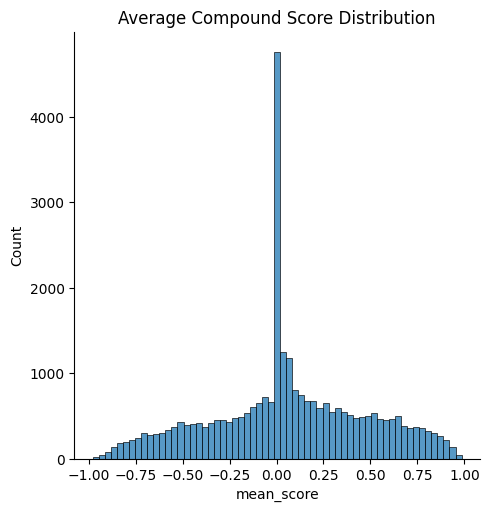

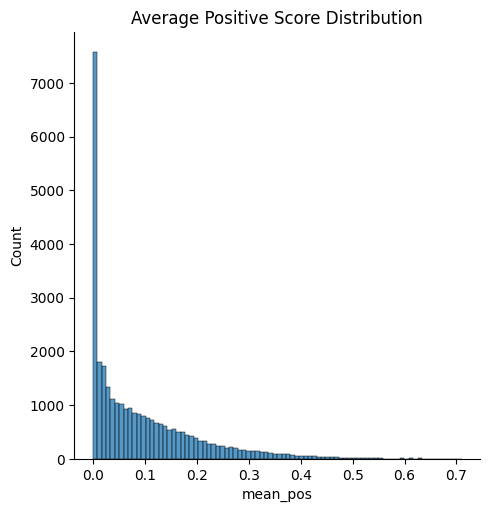

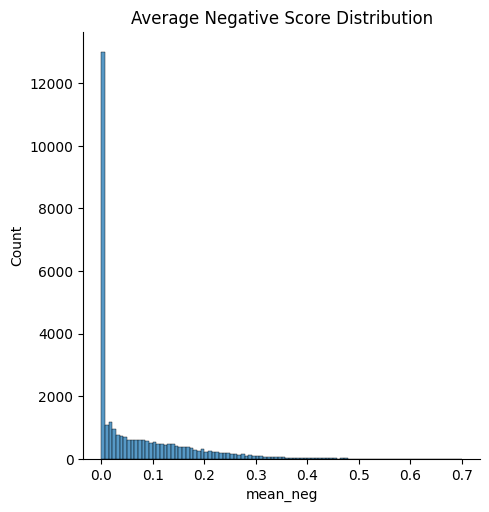

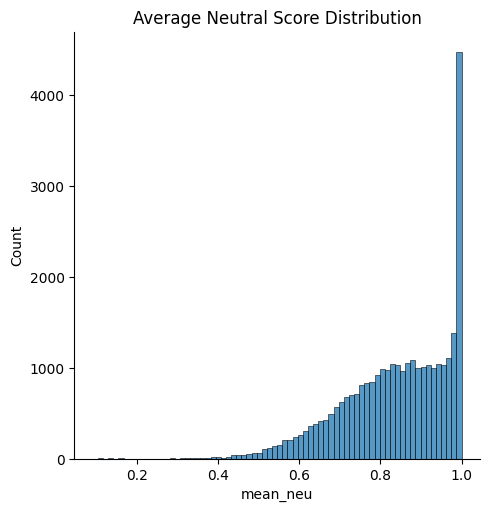

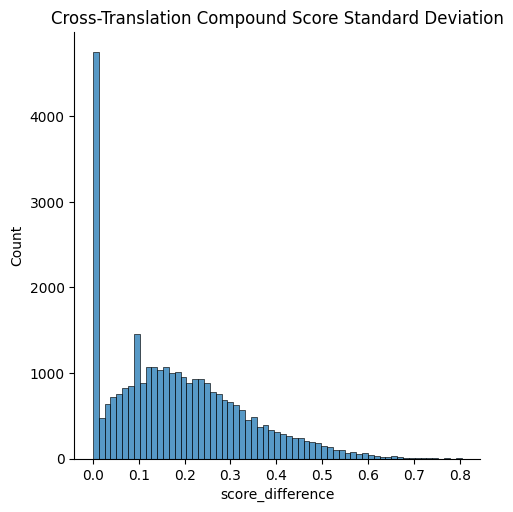

In [21]:
sns.displot(verse_scores, x="mean_score").set(title='Average Compound Score Distribution')
sns.displot(verse_scores, x="mean_pos").set(title='Average Positive Score Distribution')
sns.displot(verse_scores, x="mean_neg").set(title='Average Negative Score Distribution')
sns.displot(verse_scores, x="mean_neu").set(title='Average Neutral Score Distribution')
sns.displot(verse_scores, x="score_difference").set(title='Cross-Translation Compound Score Standard Deviation')


Notes:
- As seen above, there exists a significant amount of neutral entries in the corpus, removing them may provide with a increased polarization for the final lexicon. However this would come at a cost of a smaller lexicon.
- Adding more sources in this initial corpus could counteract this problem.

<hr>

## Secondary Corpus

### Load Secondary Corpus

Here the secondary corpus is loaded. This will be the corpus onto which the sentiment of the primary corpus is induced, and from which the sentiment lexicon is generated.

In [22]:
df_corpus2 = pd.DataFrame()
df_en2 = df_corpus2.loadBibles(filter(lambda x: f"{x.Corpus}" == 'en2', bibles))
df_en2.sample(10)

,book_number,chapter,verse,text,bible_version
24348,330,16,57,"Before thy wickedness was discovered, as at the time of thy reproach of the daughters of Syria, and all that are round about her, the daughters of the Philistines, which despise thee round about.",King James Version 1769
21752,290,45,7,"I form the light, and create darkness: I make peace, and create evil: I the LORD do all these things.",King James Version 1769
28513,470,11,24,"<J>But I say unto you, That it shall be more tolerable for the land of Sodom in the day of judgment, than for thee.</J>",King James Version 1769
24906,330,36,18,"Wherefore I poured my fury upon them for the blood that they had shed upon the land, and for their idols wherewith they had polluted it:",King James Version 1769
7881,90,25,20,"And it was so, as she rode on the ass, that she came down by the covert of the hill, and, behold, David and his men came down against her; and she met them.",King James Version 1769
6784,70,9,30,"And when Zebul the ruler of the city heard the words of Gaal the son of Ebed, his anger was kindled.",King James Version 1769
13955,180,10,17,Then they chose out of them an hundred men to accompany her and her maid; and they brought her to the tent of Holofernes.,King James Version 1769
6933,70,15,4,"And Samson went and caught three hundred foxes, and took firebrands, and turned tail to tail, and put a firebrand in the midst between two tails.",King James Version 1769
19616,280,7,8,Bind not one sin upon another; for in one thou shalt not be unpunished.,King James Version 1769
21338,290,27,3,"I the LORD do keep it; I will water it every moment: lest any hurt it, I will keep it night and day.",King James Version 1769


### Set Sentiment Scores
The sentiment scores are merged (joined) into the secondary corpus on the entries with matching book numbers, chapter numbers, and verse numbers.

In [23]:
df_en2_scores = pd.merge(df_en2,verse_scores, how='inner', on=['book_number','chapter','verse'])
df_en2_scores.head()

,book_number,chapter,verse,text,bible_version,mean_score,mean_pos,mean_neg,mean_neu,score_difference,scores
0,10,1,1,In the beginning God created the heaven and the earth.,King James Version 1769,0.700300,0.474500,0.000000,0.525500,0.000000,"[New International Version 2011:0.7003, New Living Translation 2013:0.7003, English Standard Version 2011:0.7003, Christian Standard Bible 2017:0.7003, The Message 2002:0.7003, New King James Version 1982:0.7003]"
1,10,1,2,"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.",King James Version 1769,0.080300,0.130833,0.103833,0.765167,0.090482,"[New International Version 2011:0.0, New Living Translation 2013:0.0, English Standard Version 2011:0.2023, Christian Standard Bible 2017:0.0, The Message 2002:0.0772, New King James Version 1982:0.2023]"
2,10,1,3,"And God said, Let there be light: and there was light.",King James Version 1769,0.284033,0.207333,0.000000,0.792667,0.024224,"[New International Version 2011:0.2732, New Living Translation 2013:0.2732, English Standard Version 2011:0.2732, Christian Standard Bible 2017:0.2732, The Message 2002:0.3382, New King James Version 1982:0.2732]"
3,10,1,4,"And God saw the light, that it was good: and God divided the light from the darkness.",King James Version 1769,0.510917,0.285333,0.081667,0.632833,0.129691,"[New International Version 2011:0.4588, New Living Translation 2013:0.4588, English Standard Version 2011:0.6249, Christian Standard Bible 2017:0.6249, The Message 2002:0.2732, New King James Version 1982:0.6249]"
4,10,1,5,"And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day.",King James Version 1769,0.067033,0.097667,0.072500,0.830333,0.092201,"[New International Version 2011:0.0258, New Living Translation 2013:0.0258, English Standard Version 2011:0.0258, Christian Standard Bible 2017:0.0258, The Message 2002:0.2732, New King James Version 1982:0.0258]"


### Data Pre-Processing

A second pre-processing function is defined, because, in this case the punctuation of the sentence is unimportant.

In [24]:
#Custom stopwords can be provided (useful when working with a different language)
stopwords_en2 = []

def preprocess_text_secondary(text):
    
    #remove html
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    
    #remove strange characters
    #text = text.encode("ascii",'ignore').decode('ascii','ignore')
    text = text.replace('-',' ')
    
    text = "".join([i for i in text if i not in string.punctuation])

    #text = text.lower()

    words = text.split(' ')
    
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if not w in stopwords_en2]

    text = " ".join(words)

    return text

In [25]:
#apply text cleanup
df_en2_scores["cleanText"] = df_en2_scores["text"].apply(preprocess_text_secondary)
df_en2_scores.head()

,book_number,chapter,verse,text,bible_version,mean_score,mean_pos,mean_neg,mean_neu,score_difference,scores,cleanText
0,10,1,1,In the beginning God created the heaven and the earth.,King James Version 1769,0.700300,0.474500,0.000000,0.525500,0.000000,"[New International Version 2011:0.7003, New Living Translation 2013:0.7003, English Standard Version 2011:0.7003, Christian Standard Bible 2017:0.7003, The Message 2002:0.7003, New King James Version 1982:0.7003]",In the beginning God created the heaven and the earth
1,10,1,2,"And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.",King James Version 1769,0.080300,0.130833,0.103833,0.765167,0.090482,"[New International Version 2011:0.0, New Living Translation 2013:0.0, English Standard Version 2011:0.2023, Christian Standard Bible 2017:0.0, The Message 2002:0.0772, New King James Version 1982:0.2023]",And the earth was without form and void and darkness was upon the face of the deep And the Spirit of God moved upon the face of the waters
2,10,1,3,"And God said, Let there be light: and there was light.",King James Version 1769,0.284033,0.207333,0.000000,0.792667,0.024224,"[New International Version 2011:0.2732, New Living Translation 2013:0.2732, English Standard Version 2011:0.2732, Christian Standard Bible 2017:0.2732, The Message 2002:0.3382, New King James Version 1982:0.2732]",And God said Let there be light and there was light
3,10,1,4,"And God saw the light, that it was good: and God divided the light from the darkness.",King James Version 1769,0.510917,0.285333,0.081667,0.632833,0.129691,"[New International Version 2011:0.4588, New Living Translation 2013:0.4588, English Standard Version 2011:0.6249, Christian Standard Bible 2017:0.6249, The Message 2002:0.2732, New King James Version 1982:0.6249]",And God saw the light that it was good and God divided the light from the darkness
4,10,1,5,"And God called the light Day, and the darkness he called Night. And the evening and the morning were the first day.",King James Version 1769,0.067033,0.097667,0.072500,0.830333,0.092201,"[New International Version 2011:0.0258, New Living Translation 2013:0.0258, English Standard Version 2011:0.0258, Christian Standard Bible 2017:0.0258, The Message 2002:0.2732, New King James Version 1982:0.0258]",And God called the light Day and the darkness he called Night And the evening and the morning were the first day


In [26]:
#keep only the necessary columns
clean_score = df_en2_scores[['cleanText','mean_score','mean_pos','mean_neg','mean_neu']]
clean_score = clean_score.rename(columns={
    "mean_score": "compound",
    "mean_pos": "positive",
    "mean_neg": "negative",
    "mean_neu": "neutral",
    })
clean_score.head()

,cleanText,compound,positive,negative,neutral
0,In the beginning God created the heaven and the earth,0.700300,0.474500,0.000000,0.525500
1,And the earth was without form and void and darkness was upon the face of the deep And the Spirit of God moved upon the face of the waters,0.080300,0.130833,0.103833,0.765167
2,And God said Let there be light and there was light,0.284033,0.207333,0.000000,0.792667
3,And God saw the light that it was good and God divided the light from the darkness,0.510917,0.285333,0.081667,0.632833
4,And God called the light Day and the darkness he called Night And the evening and the morning were the first day,0.067033,0.097667,0.072500,0.830333


#### Word splitting

In [27]:
clean_score["words"] = clean_score["cleanText"].str.split(" ")
clean_score.head()

,cleanText,compound,positive,negative,neutral,words
0,In the beginning God created the heaven and the earth,0.700300,0.474500,0.000000,0.525500,"[In, the, beginning, God, created, the, heaven, and, the, earth]"
1,And the earth was without form and void and darkness was upon the face of the deep And the Spirit of God moved upon the face of the waters,0.080300,0.130833,0.103833,0.765167,"[And, the, earth, was, without, form, and, void, and, darkness, was, upon, the, face, of, the, deep, And, the, Spirit, of, God, moved, upon, the, face, of, the, waters]"
2,And God said Let there be light and there was light,0.284033,0.207333,0.000000,0.792667,"[And, God, said, Let, there, be, light, and, there, was, light]"
3,And God saw the light that it was good and God divided the light from the darkness,0.510917,0.285333,0.081667,0.632833,"[And, God, saw, the, light, that, it, was, good, and, God, divided, the, light, from, the, darkness]"
4,And God called the light Day and the darkness he called Night And the evening and the morning were the first day,0.067033,0.097667,0.072500,0.830333,"[And, God, called, the, light, Day, and, the, darkness, he, called, Night, And, the, evening, and, the, morning, were, the, first, day]"


<h3>Word Scores</h3>

In [28]:
word_score = clean_score.explode("words")
word_score = word_score[word_score["words"].notnull()]
word_score = word_score[word_score["words"] != ""]

#Add a lower variant of words to later use in identifying names.
word_score["words_lower"] = word_score["words"].str.lower()
word_score.head()

,cleanText,compound,positive,negative,neutral,words,words_lower
0,In the beginning God created the heaven and the earth,0.7003,0.4745,0.0,0.5255,In,in
0,In the beginning God created the heaven and the earth,0.7003,0.4745,0.0,0.5255,the,the
0,In the beginning God created the heaven and the earth,0.7003,0.4745,0.0,0.5255,beginning,beginning
0,In the beginning God created the heaven and the earth,0.7003,0.4745,0.0,0.5255,God,god
0,In the beginning God created the heaven and the earth,0.7003,0.4745,0.0,0.5255,created,created


### Remove names
By identifying words that only occur with a uppercase first letter, we can remove names of persons and places from the lexicon.

In [29]:
word_score_group = word_score.groupby('words_lower').agg(
    compound = pd.NamedAgg(column="compound", aggfunc = "mean"),
    positive = pd.NamedAgg(column="positive", aggfunc = "mean"),
    negative = pd.NamedAgg(column="negative", aggfunc = "mean"),
    neutral = pd.NamedAgg(column="neutral", aggfunc = "mean"),
    occurrences = pd.NamedAgg(column="words", aggfunc = "count"),
    word_variance = pd.NamedAgg(column="words", aggfunc = (lambda x: sorted(pd.Series.unique(x),reverse=True))),
)

word_score_group = word_score_group.reset_index()
word_score_group

,words_lower,compound,positive,negative,neutral,occurrences,word_variance
0,a,0.075650,0.097287,0.072484,0.829622,8280,"[a, A]"
1,aaron,0.000120,0.041078,0.036830,0.922087,319,[Aaron]
2,aaronites,0.000000,0.000000,0.000000,1.000000,2,[Aaronites]
3,aarons,0.124712,0.057430,0.024177,0.918403,31,[Aarons]
4,abaddon,-0.152933,0.000000,0.040167,0.959833,1,[Abaddon]
...,...,...,...,...,...,...,...
12740,zuph,-0.043106,0.021000,0.034056,0.944889,3,[Zuph]
12741,zur,-0.362717,0.000800,0.085867,0.913300,5,[Zur]
12742,zuriel,0.004300,0.010667,0.000000,0.989333,1,[Zuriel]
12743,zurishaddai,0.054230,0.010667,0.000000,0.989333,5,[Zurishaddai]


In [30]:
#Select the lower case of the word if available
word_score_group['word'] = word_score_group['word_variance'].str[0]
word_score_group

,words_lower,compound,positive,negative,neutral,occurrences,word_variance,word
0,a,0.075650,0.097287,0.072484,0.829622,8280,"[a, A]",a
1,aaron,0.000120,0.041078,0.036830,0.922087,319,[Aaron],Aaron
2,aaronites,0.000000,0.000000,0.000000,1.000000,2,[Aaronites],Aaronites
3,aarons,0.124712,0.057430,0.024177,0.918403,31,[Aarons],Aarons
4,abaddon,-0.152933,0.000000,0.040167,0.959833,1,[Abaddon],Abaddon
...,...,...,...,...,...,...,...,...
12740,zuph,-0.043106,0.021000,0.034056,0.944889,3,[Zuph],Zuph
12741,zur,-0.362717,0.000800,0.085867,0.913300,5,[Zur],Zur
12742,zuriel,0.004300,0.010667,0.000000,0.989333,1,[Zuriel],Zuriel
12743,zurishaddai,0.054230,0.010667,0.000000,0.989333,5,[Zurishaddai],Zurishaddai


### Word Selection
- In selecting words to form part of the corpus, words with very a low frequency should be ignored. As the score of words with very low frequency will not be able to be averaged over multiple instances, and can therefor skew the lexicon.
- Low frequency words will also overlap with many names.

Notes:
- According to the GeeksForGeeks example (‘Python | Sentiment Analysis using VADER’, 2019), 0.05 can be used to select "significant" words, for this proposal, 0.10 is used as only one secondary corpus is used, and therefore the rankings closer to 0 may not be as accurate as in the final product.

In [31]:
#an occurence minimum of 5 is selected, as lower numbers tend to provide at a glance, less accurate results
occurence_min = 5

#used in the wordcloud generation
significance = 0.10

In [32]:
word_lexicon = word_score_group[['word','compound','positive','negative','neutral','occurrences']]
word_lexicon = word_lexicon[word_lexicon['word'] != np.nan]

total_count = word_lexicon['word'].count()
excluded_count = word_lexicon[word_lexicon['occurrences'] <= occurence_min]['word'].count()

display(HTML(f'<b>Untrimmed Lexicon Length:</b> {total_count}'))
display(HTML(f'<b>Words to exclude:</b> {excluded_count}'))
display(HTML(f'<b>Words to remain:</b> {total_count-excluded_count}'))

word_lexicon[word_lexicon['occurrences'] >= occurence_min].sort_values(by='compound').head()

,word,compound,positive,negative,neutral,occurrences
7572,murderer,-0.791922,0.056050,0.361492,0.582517,20
8355,perils,-0.763083,0.012167,0.303667,0.684167,8
2714,cruelty,-0.724770,0.044667,0.294533,0.660833,5
6418,killing,-0.718473,0.040300,0.293200,0.666400,5
7573,murderers,-0.695848,0.056633,0.274483,0.668933,10


In [33]:
names = word_lexicon[word_lexicon['word'].str[0].str.isupper()]
names.sort_values(by='compound')

,word,compound,positive,negative,neutral,occurrences
9020,Raca,-0.971183,0.000000,0.363500,0.636500,1
834,Associate,-0.929433,0.014000,0.393500,0.592500,1
10416,Sippai,-0.875400,0.000000,0.275667,0.724333,1
8321,Peors,-0.865000,0.024833,0.202500,0.772667,1
9038,Rahel,-0.864133,0.068167,0.345833,0.585833,1
...,...,...,...,...,...,...
6325,Judea,0.848550,0.198167,0.006167,0.795667,1
2279,Colosse,0.863567,0.356167,0.000000,0.643833,1
9035,Raguel,0.879033,0.225167,0.000000,0.774833,1
7350,Midianite,0.879033,0.225167,0.000000,0.774833,1


In [34]:
word_lexicon_clean = word_lexicon[word_lexicon['word'].str[0].str.isupper() == False]
word_lexicon_clean = word_lexicon_clean.set_index('word')
word_lexicon_clean[word_lexicon_clean['occurrences'] >= occurence_min].sort_values(by='compound')

,compound,positive,negative,neutral,occurrences
word,,,,,
murderer,-0.791922,0.056050,0.361492,0.582517,20
perils,-0.763083,0.012167,0.303667,0.684167,8
cruelty,-0.724770,0.044667,0.294533,0.660833,5
killing,-0.718473,0.040300,0.293200,0.666400,5
murderers,-0.695848,0.056633,0.274483,0.668933,10
...,...,...,...,...,...
unsearchable,0.748863,0.315333,0.028767,0.655867,5
promises,0.763304,0.288474,0.018346,0.693141,13
wellbeloved,0.766047,0.326861,0.013222,0.659917,6


#### Odd words

In [35]:
word_lexicon_clean[
    (word_lexicon_clean['occurrences'] >= occurence_min)
    & (word_lexicon_clean['positive'] >= word_lexicon_clean['negative'])
    & (word_lexicon_clean['compound'] < -significance)
    ].sort_values(by='neutral',ascending=True)

,compound,positive,negative,neutral,occurrences
word,,,,,
physician,-0.137569,0.142667,0.133167,0.724083,6


c:\Projects\UoL\(DSM020-2023-APR) Data programming in Python\DSM020_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


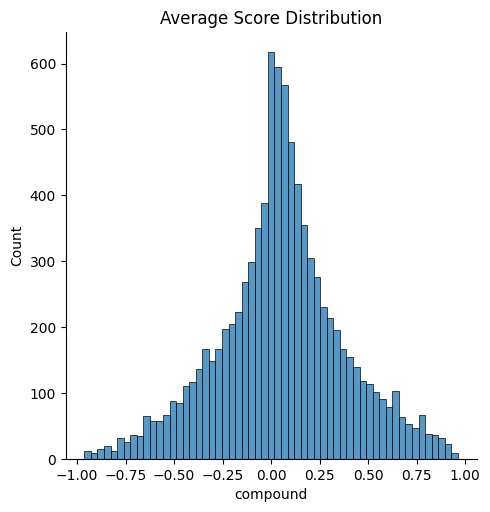

In [36]:
sns.displot(word_lexicon_clean, x="compound").set(title='Average Score Distribution')

Notes:
- Note that there tends to be a lot of neutral words in the lexicon, but the distribution is far less neutral that that of the primary corpus.
- From this it is clear that the use of average sentiment of words does mitigate the that in some degree.
- A larger secondary corpus can also be useful to achieve a better distribution.

### Positive Word-Cloud

In [37]:
word_lexicon_clean = word_lexicon_clean.reset_index()

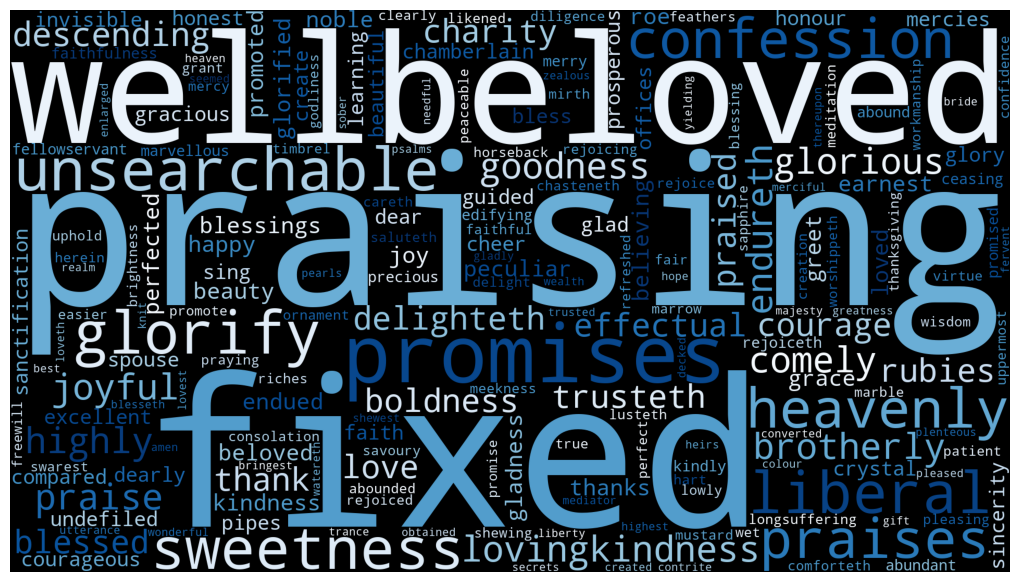

In [38]:
positive_lexicon = word_lexicon_clean[(word_lexicon_clean['occurrences'] >= occurence_min) & word_lexicon_clean["compound"]>=significance]

positive_words = dict(zip(positive_lexicon['word'].tolist(), positive_lexicon['compound'].tolist()))

wordcloud = WordCloud(width = 1920, height = 1080,
                background_color ='black',
                colormap = 'Blues',
                min_font_size = 10).generate_from_frequencies(positive_words)

# plot the WordCloud image                      
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('en2_positive_wordcloud.png')

display(HTML('<h3>Positive English Wordcloud:</h3>'))
plt.show()

### Negative Word-Cloud

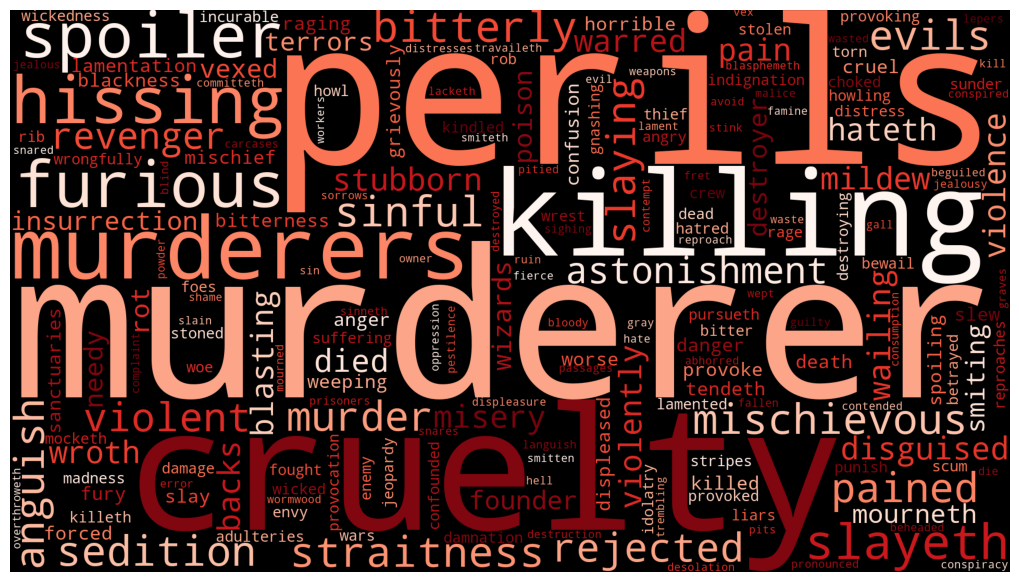

In [39]:
negative_lexicon = word_lexicon_clean[(word_lexicon_clean['occurrences'] >= occurence_min) & (word_lexicon_clean["compound"] <= -significance)]

negative_words = dict(zip(negative_lexicon['word'].tolist(), [x*-1 for x in negative_lexicon['compound'].tolist()]))

wordcloud = WordCloud(width = 1920, height = 1080,
                background_color ='black',
                colormap = "Reds",
                min_font_size = 10).generate_from_frequencies(negative_words) 

# plot the WordCloud image                      
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('en2_negative_wordcloud.png')

display(HTML('<h3>Negative English Wordcloud:</h3>'))
plt.show()

In [40]:
word_lexicon_clean[word_lexicon_clean['occurrences'] >= occurence_min][['word','compound']].set_index('word').sort_values(by='compound').to_csv("en2_sentiment_lexicon.csv")

Notes:
- By analyzing the word-clouds it can be concluded that a majority of the words has been correctly identified
- However, it can also be determined that it would we useful to have some manual corrections applied to odd words
- A larger secondary corpus should both expand the available vocabulary as well as average out the scores for words currently scored incorrectly.

<hr>

## Ethics

The ph4.org site primarily provides their bibles for use as modules in the 'MyBible' Android app, a freeware solution to browse bibles offline. ph4 also have no limitations on the use of any of the materials that they provide.

Per the website (<i>Article posting terms</i>): 

"We respect respect for the work of every person, so we try to give a mention of the author and a link at the top, not at the bottom of the pages.
But we give the report it may turn out that someone has already seized your work or gave it away.

If this is your case, let us know (at the bottom of the page), we will correct the situation and apologize.
Although, until now we have not had such questions."

None of the materials in the current iteration of the project contain any personal information. It is worth noting that the King James Version, also fall under the 'Public domain', according to Bible Gateway, while simultaneously being protected by "Crown Copyright" in the UK, per The Guardian. (<i>The Guardian</i>, 2011)

None of the materials (phrases/sentences/ideas) are directly presented in the resulting lexicon.

<hr>

## Conclusion
Through the preliminary investigation in this proposal, it can be concluded that sentiment induction using parallel corpora is feasible, producing clear polarization of sentiment in the resulting lexicon. This process can be further fine tuned by removing some of the completely neutral verses from the primary corpus, and with some manual corrections to the lexicon itself.

In the further study would implement these changes, as well as finalize the pipeline to produce lexicons for non-english languages. It would then also be beneficial to test the lexicon output against another source, such as news articles, and compare the resulting sentiment scores against other existing methods.

### Notes
- Making use of the lexicon for sentiment analysis in a different text corpus will likely result in higher positive and negative polarization in text concerning religion and christianity. However this being a minor problem considering that with this method, sentiment induction can generate sizeable sentiment lexicons for many lesser spoken languages.
- This approach to lexicon building does require that the target language have a bible translation, and although many languages will satisfy this, it may still exclude some. With minor alterations partial bible translations can be used, as well as other parallel corpuses.
- Some biases will likely be present in the lexicons, which may be positive or negative in the context of the bible, but may not be in a different context. This may require some manual corrections, but will also likely be less prevalent if a larger (more bibles) secondary corpus is used. As this will average out over more occurrences.

<hr>

<h2 id="save-dependencies">Save Dependencies</h2>

Done to ensure that project can reliably resolve dependencies at a later time and on a different machine.

In [41]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


<hr>
<h2 id="references">References</h2>

<div class="csl-bib-body" style="line-height: 1.35; ">
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Article posting terms</i> (no date) <i>ph4.org</i>. Available at: <a href="https://www.ph4.org/aboutarticle.php">https://www.ph4.org/aboutarticle.php</a> (Accessed: 16 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Article%20posting%20terms&amp;rft.description=Internet%20review%20in%20simple%20terms.%20A%20structured%20directory%20of%20Internet%20resources.&amp;rft.identifier=https%3A%2F%2Fwww.ph4.org%2Faboutarticle.php&amp;rft.language=ru"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Hota, H.S., Sharma, D.K. and Verma, N. (2021) ‘Lexicon-based sentiment analysis using Twitter data’, <i>Data Science for COVID-19</i>, pp. 275–295. Available at: <a href="https://doi.org/10.1016/B978-0-12-824536-1.00015-0">https://doi.org/10.1016/B978-0-12-824536-1.00015-0</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1016%2FB978-0-12-824536-1.00015-0&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Lexicon-based%20sentiment%20analysis%20using%20Twitter%20data&amp;rft.jtitle=Data%20Science%20for%20COVID-19&amp;rft.stitle=Data%20Science%20for%20COVID-19&amp;rft.aufirst=H.S.&amp;rft.aulast=Hota&amp;rft.au=H.S.%20Hota&amp;rft.au=Dinesh%20K.%20Sharma&amp;rft.au=Nilesh%20Verma&amp;rft.date=2021&amp;rft.pages=275-295&amp;rft.spage=275&amp;rft.epage=295"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Pandas &amp; Seaborn - A guide to handle &amp; visualize data in Python</i> (no date) <i>Tryolabs</i>. Available at: <a href="https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly">https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Pandas%20%26%20Seaborn%20-%20A%20guide%20to%20handle%20%26%20visualize%20data%20in%20Python&amp;rft.description=An%20overview%20of%20Pandas%2C%20a%20Python%20library%2C%20which%20is%20old%20but%20gold%20and%20a%20must-know%20if%20you're%20attempting%20to%20do%20any%20work%20with%20data%20in%20the%20Python%20world%2C%20and%20a%20glance%20of%20Seaborn%2C%20a%20Python%20library%20for%20making%20statistical%20visualizations.%20Read%20more%20about%20it%20in%20this%20blog%20post!&amp;rft.identifier=https%3A%2F%2Ftryolabs.com%2Fblog%2F2017%2F03%2F16%2Fpandas-seaborn-a-guide-to-handle-visualize-data-elegantly&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Parallel corpus - Glottopedia</i> (no date). Available at: <a href="http://www.glottopedia.org/index.php/Parallel_corpus">http://www.glottopedia.org/index.php/Parallel_corpus</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Parallel%20corpus%20-%20Glottopedia&amp;rft.identifier=http%3A%2F%2Fwww.glottopedia.org%2Findex.php%2FParallel_corpus"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Ploomber (2021) <i>On writing clean Jupyter notebooks</i>. Available at: <a href="https://ploomber.io/blog/clean-nbs/">https://ploomber.io/blog/clean-nbs/</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=On%20writing%20clean%20Jupyter%20notebooks&amp;rft.description=10%20rules%20for%20writing%20readable%20and%20maintainable%20notebooks&amp;rft.identifier=https%3A%2F%2Fploomber.io%2Fblog%2Fclean-nbs%2F&amp;rft.aulast=Ploomber&amp;rft.au=Ploomber&amp;rft.date=2021-07-20&amp;rft.language=en-us"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">‘Python | Sentiment Analysis using VADER’ (2019) <i>GeeksforGeeks</i>, 23 January. Available at: <a href="https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/">https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=blogPost&amp;rft.title=Python%20%7C%20Sentiment%20Analysis%20using%20VADER&amp;rft.description=A%20Computer%20Science%20portal%20for%20geeks.%20It%20contains%20well%20written%2C%20well%20thought%20and%20well%20explained%20computer%20science%20and%20programming%20articles%2C%20quizzes%20and%20practice%2Fcompetitive%20programming%2Fcompany%20interview%20Questions.&amp;rft.identifier=https%3A%2F%2Fwww.geeksforgeeks.org%2Fpython-sentiment-analysis-using-vader%2F&amp;rft.date=2019-01-23&amp;rft.language=en-us"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Roul, A. (2021) ‘Sentiment Analysis- Lexicon Models vs Machine Learning’, <i>Nerd For Tech</i>, 18 February. Available at: <a href="https://medium.com/nerd-for-tech/sentiment-analysis-lexicon-models-vs-machine-learning-b6e3af8fe746">https://medium.com/nerd-for-tech/sentiment-analysis-lexicon-models-vs-machine-learning-b6e3af8fe746</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=blogPost&amp;rft.title=Sentiment%20Analysis-%20Lexicon%20Models%20vs%20Machine%20Learning&amp;rft.description=Why%20are%20we%20even%20interested%20in%20Sentiment%20Analysis%3F%20Well%2C%20here%E2%80%99s%20situation%20to%20help%20you%20understand.&amp;rft.identifier=https%3A%2F%2Fmedium.com%2Fnerd-for-tech%2Fsentiment-analysis-lexicon-models-vs-machine-learning-b6e3af8fe746&amp;rft.aufirst=Abhinandan&amp;rft.aulast=Roul&amp;rft.au=Abhinandan%20Roul&amp;rft.date=2021-02-18&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Tatman, R. (no date) <i>Sentiment Lexicons for 81 Languages</i>. Available at: <a href="https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages">https://www.kaggle.com/datasets/rtatman/sentiment-lexicons-for-81-languages</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Sentiment%20Lexicons%20for%2081%20Languages&amp;rft.description=Sentiment%20Polarity%20Lexicons%20(Positive%20vs.%20Negative)&amp;rft.identifier=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Frtatman%2Fsentiment-lexicons-for-81-languages&amp;rft.aufirst=Rachael&amp;rft.aulast=Tatman&amp;rft.au=Rachael%20Tatman&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>The Guardian</i> (2011) ‘The King James Bible and eternal copyright’, 27 November. Available at: <a href="https://www.theguardian.com/books/2011/nov/27/king-james-bible-eternal-copyright">https://www.theguardian.com/books/2011/nov/27/king-james-bible-eternal-copyright</a> (Accessed: 16 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=newspaperArticle&amp;rft.title=The%20King%20James%20Bible%20and%20eternal%20copyright&amp;rft.source=The%20Guardian&amp;rft.description=Letters%3A%20Michael%20Gove%20and%20the%20government%20are%20making%20a%20gift%20of%20the%20King%20James%20Bible%20to%20every%20school%20in%20the%20UK%20but%20continue%20to%20restrict%20how%20we%20use%20it&amp;rft.identifier=https%3A%2F%2Fwww.theguardian.com%2Fbooks%2F2011%2Fnov%2F27%2Fking-james-bible-eternal-copyright&amp;rft.date=2011-11-27&amp;rft.issn=0261-3077&amp;rft.language=en-GB"></span>
  <div class="csl-entry">Wijaya, C.Y. (2021) <i>Speed up your Pandas Processing with Swifter</i>, <i>Medium</i>. Available at: <a href="https://towardsdatascience.com/speed-up-your-pandas-processing-with-swifter-6aa314600a13">https://towardsdatascience.com/speed-up-your-pandas-processing-with-swifter-6aa314600a13</a> (Accessed: 12 July 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Speed%20up%20your%20Pandas%20Processing%20with%20Swifter&amp;rft.description=Don%E2%80%99t%20let%20your%20data%20processing%20taking%20you%20too%20long&amp;rft.identifier=https%3A%2F%2Ftowardsdatascience.com%2Fspeed-up-your-pandas-processing-with-swifter-6aa314600a13&amp;rft.aufirst=Cornellius%20Yudha&amp;rft.aulast=Wijaya&amp;rft.au=Cornellius%20Yudha%20Wijaya&amp;rft.date=2021-10-12&amp;rft.language=en"></span>
</div>